In [7]:
from sklearn.metrics import ndcg_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
def evaluate(prediction, ground_truth, mask):
    assert ground_truth.shape == prediction.shape, 'shape mis-match'
    performance = {}
    performance['mse'] = np.linalg.norm((prediction - ground_truth) * mask) ** 2 / np.sum(mask)
    # performance['mse'] = np.mean(mask * (prediction - ground_truth) ** 2)

    # top5
    bt_long5 = 1.0
    ndcg_score_top5 = 0.0
    sharpe_li5 = []

    num_stocks = prediction.shape[0]
    y_score = np.array([[5, 4, 3, 2, 1]])

    for i in range(prediction.shape[1]):
        # sort index
        rank_gt = np.argsort(ground_truth[:, i])
        # ground truth top 5
        gt_top5 = []
        y_true_ = np.zeros(num_stocks, np.int32)
        for j in range(1, prediction.shape[0] + 1):
            cur_rank = rank_gt[-1 * j]
            if mask[cur_rank][i] < 0.5:
                continue
            if len(gt_top5) < 5:
                gt_top5.append(cur_rank)
            y_true_[cur_rank] = num_stocks - j + 1

        # predict top 5
        rank_pre = np.argsort(prediction[:, i])
        k = 0
        pre_top5 = []
        y_true = np.zeros((1, 5), np.int32)
        for j in range(1, prediction.shape[0] + 1):
            cur_rank = rank_pre[-1 * j]
            if mask[cur_rank][i] < 0.5:
                continue
            if len(pre_top5) < 5:
                pre_top5.append(cur_rank)
                y_true[0][k] = y_true_[cur_rank]
                k += 1

        # sklearn.metrics.ndcg_score(y_true, y_score, k)
        # ndcg_score_top5 = ndcg_score(y_true, y_score)
        if len(pre_top5) == 5:
            ndcg_score_top5 += ndcg_score(y_true, y_score)
        else:
            ndcg_score_top5 += 0.0

        # back testing on top 5
        real_ret_rat_top5 = 0
        for pre in pre_top5:
            real_ret_rat_top5 += ground_truth[pre][i]
        real_ret_rat_top5 /= 5
        # 累计收益率计算公式
        bt_long5 *= (1 + real_ret_rat_top5)
        sharpe_li5.append(real_ret_rat_top5)

    performance['btl5'] = bt_long5 - 1
    sharpe_li5 = np.array(sharpe_li5)
    performance['sharpe5'] = (np.mean(sharpe_li5) / np.std(sharpe_li5)) * 15.87  # To annualize
    performance['ndcg_score_top5'] = ndcg_score_top5 / prediction.shape[1]

    # 返回技术指标[mse,ndcg_score_top5,btl5(累计收益率),sharpe5(夏普比率)]
    res_list = [performance['mse'], performance['ndcg_score_top5'], performance['btl5'], performance['sharpe5']]
    return res_list


def evaluate_topk(prediction, ground_truth, mask):
    assert ground_truth.shape == prediction.shape, 'shape mis-match'
    # print('gt_rt',np.max(ground_truth))
    performance = {}
    # performance['mse'] = np.linalg.norm((prediction - ground_truth) * mask) ** 2 / np.sum(mask)

    # top1
    bt_long1 = 1.0
    sharpe_li1 = []
    irr1 = []
    # top5
    bt_long5 = 1.0
    ndcg_score_top5 = 0.0
    sharpe_li5 = []
    irr5 = []
    selected_stock5 = []
    # top10
    bt_long10 = 1.0
    ndcg_score_top10 = 0.0
    sharpe_li10 = []
    irr10 = []
    # top15
    bt_long15 = 1.0
    ndcg_score_top15 = 0.0
    sharpe_li15 = []
    irr15 = []
    # top20
    bt_long20 = 1.0
    ndcg_score_top20 = 0.0
    sharpe_li20 = []
    irr20 = []

    for i in range(prediction.shape[1]):
        # 返回索引
        rank_gt = np.argsort(ground_truth[:, i])
        # 真实前20名排序
        gt_top20 = []
        for j in range(1, prediction.shape[0] + 1):
            cur_rank = rank_gt[-1 * j]
            if mask[cur_rank][i] < 0.5:
                continue
            if len(gt_top20) < 20:
                gt_top20.append(cur_rank)

        # 预测前20名排序
        rank_pre = np.argsort(prediction[:, i])
        pre_top20 = []
        for j in range(1, prediction.shape[0] + 1):
            cur_rank = rank_pre[-1 * j]
            if mask[cur_rank][i] < 0.5:
                continue
            if len(pre_top20) < 20:
                pre_top20.append(cur_rank)
        # 保存前5选股
        selected_stock5.append(pre_top20[:5])
        # sklearn.metrics.ndcg_score(y_true, y_score, k)
        ndcg_score_top5 += ndcg_score(np.array(list(gt_top20[:5])).reshape(1, -1),
                                      np.array(list(pre_top20[:5])).reshape(1, -1))
        ndcg_score_top10 += ndcg_score(np.array(list(gt_top20[:10])).reshape(1, -1),
                                       np.array(list(pre_top20[:10])).reshape(1, -1))
        ndcg_score_top15 += ndcg_score(np.array(list(gt_top20[:15])).reshape(1, -1),
                                       np.array(list(pre_top20[:15])).reshape(1, -1))
        ndcg_score_top20 += ndcg_score(np.array(list(gt_top20[:20])).reshape(1, -1),
                                       np.array(list(pre_top20[:20])).reshape(1, -1))

        # back testing on top1
        real_ret_rat_top1 = 0
        pre = pre_top20[0]
        real_ret_rat_top1 += ground_truth[pre][i]
        # 累计收益率计算公式
        bt_long1 *= (1 + real_ret_rat_top1)
        sharpe_li1.append(real_ret_rat_top1)
        irr1.append(bt_long1)

        # back testing on top 5
        real_ret_rat_top5 = 0
        pre_top5 = pre_top20[:5]
        for pre in pre_top5:
            real_ret_rat_top5 += ground_truth[pre][i]
        real_ret_rat_top5 /= 5
        # 累计收益率计算公式
        bt_long5 *= (1 + real_ret_rat_top5)
        sharpe_li5.append(real_ret_rat_top5)
        irr5.append(bt_long5)

        # back testing on top 10
        real_ret_rat_top10 = 0
        pre_top10 = pre_top20[:10]
        for pre in pre_top10:
            real_ret_rat_top10 += ground_truth[pre][i]
        real_ret_rat_top10 /= 10
        # 累计收益率计算公式
        bt_long10 *= (1 + real_ret_rat_top10)
        sharpe_li10.append(real_ret_rat_top10)
        irr10.append(bt_long10)

        # back testing on top 15
        real_ret_rat_top15 = 0
        pre_top15 = pre_top20[:15]
        for pre in pre_top15:
            real_ret_rat_top15 += ground_truth[pre][i]
        real_ret_rat_top15 /= 15
        # 累计收益率计算公式
        bt_long15 *= (1 + real_ret_rat_top15)
        sharpe_li15.append(real_ret_rat_top15)
        irr15.append(bt_long15)

        # back testing on top 20
        real_ret_rat_top20 = 0
        for pre in pre_top20:
            real_ret_rat_top20 += ground_truth[pre][i]
        real_ret_rat_top20 /= 20
        # 累计收益率计算公式
        bt_long20 *= (1 + real_ret_rat_top20)
        sharpe_li20.append(real_ret_rat_top20)
        irr20.append(bt_long20)

    performance['btl1'] = bt_long1 - 1
    sharpe_li1 = np.array(sharpe_li1)
    performance['sharpe1'] = (np.mean(sharpe_li1) / np.std(sharpe_li1)) * 15.87  # To annualize

    performance['btl5'] = bt_long5 - 1
    sharpe_li5 = np.array(sharpe_li5)
    performance['sharpe5'] = (np.mean(sharpe_li5) / np.std(sharpe_li5)) * 15.87  # To annualize
    performance['ndcg_score_top5'] = ndcg_score_top5 / prediction.shape[1]

    performance['btl10'] = bt_long10 - 1
    sharpe_li10 = np.array(sharpe_li10)
    performance['sharpe10'] = (np.mean(sharpe_li10) / np.std(sharpe_li10)) * 15.87  # To annualize
    performance['ndcg_score_top10'] = ndcg_score_top10 / prediction.shape[1]

    performance['btl15'] = bt_long15 - 1
    sharpe_li15 = np.array(sharpe_li15)
    performance['sharpe15'] = (np.mean(sharpe_li15) / np.std(sharpe_li15)) * 15.87  # To annualize
    performance['ndcg_score_top15'] = ndcg_score_top15 / prediction.shape[1]

    performance['btl20'] = bt_long20 - 1
    sharpe_li20 = np.array(sharpe_li20)
    performance['sharpe20'] = (np.mean(sharpe_li20) / np.std(sharpe_li20)) * 15.87  # To annualize
    performance['ndcg_score_top20'] = ndcg_score_top20 / prediction.shape[1]

    data = pd.Series(irr5)
    rolling_mean = data.rolling(window=25).mean()
    rolling_std = data.rolling(window=25).std()
    rolling_sharpe = (rolling_mean * np.sqrt(252)) / rolling_std
    
    # 返回技术指标[mse,ndcg_score_top5,btl5(累计收益率),sharpe5(夏普比率)]
    # irr: 收益率序列
    # selected_stock5: 选股序列
    return performance, irr1, irr5, selected_stock5, rolling_sharpe.tolist()

In [8]:
from utils.timefeatures import time_features
from sklearn.preprocessing import StandardScaler
import os
import pandas as pd
from torch_geometric.data import Dataset


class NASDAQ_Dataset(Dataset):
    def __init__(self, root_path, market_name,
                 flag='train', size=None,
                 features='MS', data_path='stock_sup/2013-01-01',
                 target='Close', scale=True, timeenc=0, freq='d'):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 16
            self.label_len = 8
            self.pred_len = 1
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # self.steps = self.pred_len
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        if self.scale:
            self.scaler = StandardScaler()
        self.timeenc = timeenc
        self.freq = freq

        self.market_name = market_name
        self.tickers_fname = market_name+'_tickers_qualify_dr-0.98_min-5_smooth.csv'
        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        # read tickers' name
        tickers = np.genfromtxt(
            os.path.join(self.root_path, self.data_path, '..', self.tickers_fname),
            dtype=str, delimiter='\t', skip_header=False
        )
        print('#tickers selected:', len(tickers))

        eod_data = []
        masks = []
        ground_truth = []
        base_price = []
        data_time_stamp = []

        if self.market_name == 'TSE':
            trade_dates = 1188
            valid_index = 693
            test_index = 924
        else:
            trade_dates = 1245
            valid_index = 756
            test_index = 1008
        border1s = [0, valid_index - self.seq_len, test_index - self.seq_len]
        border2s = [valid_index, test_index, trade_dates]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        # read tickers' eod data
        length = len(tickers)
        # length = 200
        for index, ticker in enumerate(tickers):
            if index >= length:
                break
            '''
            df_raw.columns: ['date', ...(other features), target feature]
            '''
            df_raw = pd.read_csv(os.path.join(self.root_path, self.data_path,
                                              self.market_name + '_' + ticker + '_1.csv'))

            cols = list(df_raw.columns)
            cols.remove(self.target)
            cols.remove('date')
            df_raw = df_raw[['date'] + cols + [self.target]]
            # print(cols)
            if self.market_name == 'NASDAQ':
                # remove the last day since lots of missing data
                df_raw = df_raw[:-1]
            if self.features == 'M' or self.features == 'MS':
                cols_data = df_raw.columns[1:]
                df_data = df_raw[cols_data]
            elif self.features == 'S':
                df_data = df_raw[[self.target]]
            data = df_data.values
            # if self.scale:
            #     train_data = data[border1s[0]:border2s[0]]
            #     self.scaler.fit(train_data)
            #     data = self.scaler.transform(data)

            data = data[border1:border2]

            df_stamp = df_raw[['date']][border1:border2]
            df_stamp['date'] = pd.to_datetime(df_stamp.date)
            if self.timeenc == 0:
                df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
                df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
                df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
                df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
                data_stamp = df_stamp.drop(columns=['date']).values
            elif self.timeenc == 1:
                data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
                data_stamp = data_stamp.transpose(1, 0)

            if index == 0:
                print('#single EOD data shape:', data.shape)
                # [股票数*交易日数*5[5-day,10-day,20-day,30-day,Close]]
                eod_data = np.zeros([length, data.shape[0], data.shape[1]], dtype=np.float32)
                masks = np.ones([length, data.shape[0]], dtype=np.float32)
                ground_truth = np.zeros([length, data.shape[0]], dtype=np.float32)
                base_price = np.zeros([length, data.shape[0]], dtype=np.float32)

            for row in range(data.shape[0]):
                if abs(data[row][-1] + 1234) < 1e-8:
                    masks[index][row] = 0.0
                elif row > 0 and abs(data[row - 1][-1] + 1234) > 1e-8:
                    ground_truth[index][row] = (data[row][-1] - data[row - 1][-1]) / data[row - 1][-1]
                for col in range(data.shape[1]):
                    if abs(data[row][col] + 1234) < 1e-8:
                        data[row][col] = 1.0  # 空值处理
            eod_data[index, :, :] = data
            base_price[index, :] = data[:, -1]
            data_time_stamp.append(data_stamp)
        data_stamp = np.array(data_time_stamp)
        print('#eod_data shape:', eod_data.shape)
        print('#masks shape:', masks.shape)
        print('#ground_truth shape:', ground_truth.shape)
        print('#base_price shape:', base_price.shape)
        print('#data_stamp shape:', data_stamp.shape)
        self.data_x = eod_data

        self.masks = masks
        self.ground_truth = ground_truth
        self.base_price = base_price
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        if self.seq_len > 16:
            mask_seq_len = 16
        else:
            mask_seq_len = self.seq_len

        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[:, s_begin:s_end, :]
        seq_y = self.data_x[:, r_begin:r_end, :]
        seq_x_mark = self.data_stamp[:, s_begin:s_end, :]
        seq_y_mark = self.data_stamp[:, r_begin:r_end, :]

        mask_batch = self.masks[:, index: index + self.seq_len + self.pred_len]
        mask_batch = np.min(mask_batch, axis=1)
        mask_batch = np.expand_dims(mask_batch, axis=1)

        price_batch = self.base_price[:, r_begin - 1: r_end - 1]
        gt_batch = self.ground_truth[:, r_begin: r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark, mask_batch, price_batch, gt_batch
        # return seq_x, seq_y, seq_x_mark, seq_y_mark
    def __len__(self):
        return self.data_x.shape[1] - self.seq_len - self.pred_len + 1

ModuleNotFoundError: No module named 'utils'

## NASDAQ

In [9]:
import matplotlib.pyplot as plt

### settings:
- seq_len: 120
- pred_len: 1
- market: NASDAQ
- date: 2017-01-03 : 2017-12-08

In [10]:
path_nas = ["../results/long_term_forecast_NASDAQ_24_1_PatchTST_NASDAQ_baseline_ftMS_sl24_ll0_pl1_dm16_nh16_el5_lr0.001_lsMSE_bs32_a10_patch8_0",
       "../results/long_term_forecast_NASDAQ_24_1_DLinear_NASDAQ_baseline_ftMS_sl24_ll0_pl1_dm16_nh16_el5_lr0.001_lsMSE_bs8_a10_patch8_0",
       "../results/long_term_forecast_NASDAQ_64_1_iTransformer_NASDAQ_baseline_ftMS_sl64_ll0_pl1_dm16_nh16_el5_lr0.001_lsMSE_bs8_a10_patch16_0"]

path_nyse = ["../results/long_term_forecast_NASDAQ_120_1_PatchTST_NASDAQ_baseline_ftMS_sl120_ll0_pl1_dm24_nh16_el5_lr0.00015_lsMSE_bs8_a8.0_nyse_0",
           "../results/long_term_forecast_NASDAQ_120_1_DLinear_NASDAQ_baseline_ftMS_sl120_ll0_pl1_dm24_nh16_el5_lr0.00015_lsMSE_bs8_a10_nyse_0",
           "../results/long_term_forecast_NASDAQ_24_1_iTransformer_NASDAQ_baseline_ftMS_sl24_ll0_pl1_dm16_nh16_el5_lr0.001_lsMSE_bs32_a10_nyse_0"]
irr5_nas_my = [1.022641509771347, 1.054984089292994, 1.0442032301699473, 1.046770101343282, 1.0164289384203575, 0.9633319031934753, 0.9405760315492678, 0.9671245477775962, 0.9493791439914463, 0.9020580666616327, 0.8843126620550411, 0.9020580660883756, 0.8872702297657206, 0.8813550947573844, 0.9168459024658606, 0.9464215758575291, 0.8931853636258211, 0.9109307690164855, 0.905015634158251, 0.9198034721219988, 0.9109307699673114, 0.9020580678827909, 0.9286761739886054, 0.9375488764200731, 0.9523367127887918, 0.9242398225576788, 0.9552942794883281, 0.9582518468344511, 0.9434640095817661, 0.9552942790106819, 0.958251846355326, 0.943464009110035, 0.9405064417542849, 0.9345913071043136, 0.91684590339843, 0.9050156338589536, 0.8902277959000963, 0.9345913066846568, 0.9079732002673777, 0.8798763101515786, 0.8846068279436868, 0.7568828490597235, 0.7947269920766313, 0.8609542433900764, 0.8893373518305635, 0.8562237276627735, 0.8373016556018735, 0.8562237269501554, 0.842032173315002, 0.8751457996238281, 0.9035289073259345, 0.8893373545038169, 0.8656847647948583, 0.851493212066646, 0.8467626941072847, 0.8704152830285752, 0.9377154313045096, 0.9063086950895752, 0.8883619885402593, 0.9063086953627423, 0.9556621379662038, 0.9601488147350379, 0.9197687229917233, 0.9579054762410681, 0.9511754612429653, 0.9661386800200001, 0.9477360377931191, 0.9569373586340861, 0.9431353774313854, 0.9979975009371497, 0.9537513075413876, 0.9685000390921488, 0.979067754286696, 0.9386938275157115, 0.9689742726621778, 0.9790677549698847, 0.9588807915703061, 0.9891612371310798, 0.999757166924192, 0.9945500981912792, 1.1973515139734614, 1.109795187725699, 1.2160601320659492, 1.1973515146321263, 1.1561925554245505, 1.3462721062631267, 1.4108193985482522, 1.3486154791356675, 1.362438572147312, 1.2385805164426624, 1.2489020212846598, 1.3314740522892072, 1.3291768230843366, 1.2184503700618217, 1.2317742997884695, 1.2441793371131855, 1.1780191338898878, 1.1872080504187614, 1.2000725335778015, 1.2055858836897257, 1.2175314753607553, 1.2019103170297494, 1.1743435667007753, 1.1605601910323637, 1.1908836164204533, 1.1203707690768892, 1.1360402901475992, 1.0890317265924743, 1.1830488541848305, 1.2247589118624342, 1.1754652086233726, 1.1640897387636218, 1.1792570312506483, 1.0956876312534936, 1.0771166544179958, 1.1049731205178308, 1.1792570315845592, 1.2337020986564164, 1.4109381797727607, 1.4033114867244485, 1.3513369868288954, 1.3201522864745356, 1.4552859895045775, 1.34094208630192, 1.2889675870264734, 1.330547185368804, 1.372126784911579, 1.4033114854980369, 1.528050287229447, 1.4348296098376665, 1.333920628405093, 1.2954791122518994, 1.3502582715360851, 1.419453001404474, 1.3790894100877509, 1.3580346098651086, 1.3931309813163144, 1.4148986528993819, 1.4040148170977118, 1.4257824885995312, 1.540062759132402, 1.5442648403550399, 1.4707284180160296, 1.6178012620091886, 1.6425005179982362, 1.683449283230828, 1.6702973357055872, 1.714124379934994, 1.7555165868121767, 1.7311682291655512, 1.7189940503909444, 1.6800366786702114, 1.5899477555207795, 1.5631645629102198, 1.6118612796353193, 1.6045567723325966, 1.6252163015516166, 1.602816689293147, 1.5804170767584709, 1.5731674574508925, 1.6166651751279182, 1.6094155551439169, 1.703660607960298, 1.7399087048542117, 1.7790958371748997, 1.7941093034281947, 1.7866025701333053, 1.8466564411130695, 1.9142170401003777, 1.8992035722313172, 1.9064524408512487, 2.0731456518876064, 2.215575501471433, 2.2700887842548108, 2.410265790707127, 2.4611152819894433, 2.4475554179810857, 2.5107181374745036, 2.4001833781758073, 2.3370206572268977, 2.256105484257676, 2.2204076122989624, 2.189469456758645, 2.151391728813556, 2.1347327221259533, 2.1466320127304814, 2.141872296557005, 2.220407611012178, 2.5440683187563873, 2.4170185958058, 2.431320481174558, 2.4599242521007434, 2.474226137234097, 2.4599242523674447, 2.4456223672325406, 2.4456223672325406, 2.3884148260523337, 2.3884148260523337, 2.4170185974897915, 2.3741129413536237, 2.5314336814148795, 2.4456223700206405, 2.5028299112660664, 2.703056299691943, 2.574339330642405, 2.588641216158952, 2.688754415027928, 2.5314336766997334, 2.5171317914939997, 2.4456223634681367, 2.4599242487411743, 2.4599242487411743, 2.431320478513532, 2.6478753308072993, 2.6642810020278667, 2.6117828551091726, 2.6117828551091726, 2.221327863133027, 2.2836694124605703, 2.1196127045332913, 2.1852353870506906, 2.1852353870506906, 2.283669411807617, 2.3722600320212583, 2.323043017423668, 2.59209602060417, 2.444444983778235, 2.496943133146572, 2.601939425161799, 2.759433867184601, 2.678748665788578, 2.711022744896981]
irr5_nyse_my = [1.0426487103104591, 1.1077441104946304, 1.1930415289943317, 1.212121214402103, 1.194163863395385, 1.21099888055087, 1.2053872082946995, 1.1773288471907124, 1.1818181851138914, 1.222222227624953, 1.2300785685833384, 1.2334455718662432, 1.2614178790461654, 1.2281175115767677, 1.2068052768246706, 1.2187934092644552, 1.1841610289606483, 1.1761689409771547, 1.1735049117330671, 1.1814969995101372, 1.1708408827702987, 1.1495286489316006, 1.2014772221050665, 1.1082361954038948, 1.0602836664478412, 1.07493582788097, 1.1282164142295628, 1.134876487459127, 1.1175602965406939, 1.0922520170583876, 1.108236192932665, 1.0283153142697903, 1.0176591972914268, 1.1375405170983273, 1.0642797099100443, 1.1841610258273152, 1.1495286459437895, 1.1415365582369674, 1.105572164224068, 1.0829279155090161, 1.0602836664152577, 1.0989120926388882, 1.0669437406371765, 0.9657106243071255, 0.9923509172922171, 0.991018902585721, 1.0003430055012381, 0.9830268155762789, 0.9257501863134593, 0.9284142156011606, 0.9670426420497683, 0.9856908479878693, 0.9617145844553198, 0.9603825698326254, 0.953722496534676, 0.9310782474244443, 0.9324102621182146, 0.936406305947376, 0.9483944377641453, 0.9856908499449928, 0.9776987617789423, 0.9803627910653746, 0.9350742924062835, 0.9483944393889561, 0.9004419123883227, 0.905769971110978, 0.8857897506637864, 0.9523904805213886, 0.9883548780161544, 0.968374657286452, 0.9723707011817547, 0.9643786134675001, 1.2028092317990173, 1.1770577408511331, 1.1792036984328809, 1.185641571470594, 1.2071011483541518, 1.265042003978793, 1.272552855596025, 1.2982497090020964, 1.3292064832359083, 1.2711625335597594, 1.2285969706395474, 1.3427500791498095, 1.3388804824943472, 1.464642382196911, 1.4530561004245197, 1.4169341620225813, 1.4292019902537758, 1.3903538666707853, 1.3658182090728277, 1.3726336690278316, 1.376722945247431, 1.3126576196764732, 1.3065237057600656, 1.3351486382882474, 1.3269700858814464, 1.3889907733378513, 1.4005770561407842, 1.1299772526275118, 1.0942937610153105, 1.0110322827437646, 0.9738619766802602, 1.0467157768209177, 1.0214399704191526, 1.0199531582115964, 1.0615838985101138, 1.0244135922012465, 1.0645575196116428, 1.094293762799575, 1.0452289604031948, 1.073478392449486, 1.0541498336769626, 1.0437421485829246, 1.073478392952039, 1.0407685259366557, 1.054149835533686, 1.0690179568422842, 1.099909729658177, 1.1381179764342815, 1.170635633085539, 1.135516564877945, 1.1639462879013251, 1.2308397524740429, 1.2793375166530512, 1.3334203000951868, 1.2778455813112917, 1.2521516341832888, 1.226457688159938, 1.17678272496006, 1.1134043228264192, 1.1168301822844604, 1.1682180755112204, 1.2315964759872664, 1.236735264956808, 1.2675679992327786, 1.3549274181017308, 1.3287149258045508, 1.3032408134557525, 1.2947494427705044, 1.3836048010365705, 1.3121929414352822, 1.2988032178174287, 1.2720237708504087, 1.2809502536378417, 1.3032664606792714, 1.2407810828930779, 1.1604427439189122, 1.1738324681698642, 1.1559795030158335, 1.0622514393937101, 1.022082265752871, 0.9551336475210923, 0.9640601299255486, 1.0176190264315683, 1.0131557850543165, 0.9908395792495363, 0.9719569795387876, 0.9928272213974043, 0.9938210424253822, 1.0494750225190577, 1.0494750225190577, 1.106719114798628, 1.0780970678021626, 1.230747979488667, 1.2183864177112789, 1.1944358912819344, 1.2253397956132666, 1.344107952471764, 1.302685758761881, 1.311984618891548, 1.307757864373913, 1.310293917117802, 1.5638991838406409, 1.4367410284721605, 1.3826622704511737, 1.6954567164268841, 1.7085963928647225, 1.8240472328586805, 1.845519242890755, 1.8369304385936016, 2.0665467434178018, 2.060414557272675, 2.1254157346069524, 2.1365565272154314, 2.181119699079572, 2.1241778689000266, 2.1786439688127484, 2.286338304165752, 2.261994557680465, 2.227123786424464, 2.1717226964256615, 2.2077334034114586, 2.184187940137695, 2.2008082672301357, 2.19942324000277, 2.098316252744331, 2.074770790084752, 2.0373750530306505, 2.0415301348652677, 2.0249098083369343, 2.06784565337553, 2.063690571639519, 2.0138295903841734, 1.9778188809958814, 1.9293429272357132, 1.8961022741433018, 1.8448562654931326, 1.8767118933295377, 1.9113375726896702, 1.9418081729541659, 1.5553855669055614, 1.578931030220153, 1.7188187821956185, 1.6190968233490335, 1.638487205189334, 1.6412572596175958, 1.6315620693711261, 1.6260219603620252, 1.6274069875469663, 1.7451343069057392, 1.7924162721029047, 1.7924162721029047, 1.8289523356196522, 1.8633392178970092, 1.9020244615234227, 1.913490566070242, 2.0092662678726168, 2.0879288169403516, 2.159633553967225, 2.1024877930073296, 2.1382038920447433]
irr5_nas_my = [x-1 for x in irr5_nas_my]
irr5_nyse_my = [x-1 for x in irr5_nyse_my]

data = pd.Series(irr5_nas_my)
rolling_mean = data.rolling(window=25).mean()
rolling_std = data.rolling(window=25).std()
rolling_sharpe_nas_my = (rolling_mean * np.sqrt(252)) / rolling_std

data = pd.Series(irr5_nyse_my)
rolling_mean = data.rolling(window=25).mean()
rolling_std = data.rolling(window=25).std()
rolling_sharpe_nyse_my = (rolling_mean * np.sqrt(252)) / rolling_std
    
nan = None
irr5_nas_ci = [0.02756245471537122, 0.04060600761540889, 0.05087306537550207, 0.03455252718142021, 0.040247055536404064, 0.03503750957331131, 0.03507114066819206, 0.03200606955984675, 0.04527370577982204, 0.05563356211207493, 0.05615017477575135, 0.02171203845564862, 0.04422273467983673, 0.032039236924243264, 0.0279267389265212, 0.009541266417494088, 0.0038489355257447233, 0.020551745198214677, 0.011454211066124431, 0.026633014425378354, 0.019169594402249635, 0.012747633416740012, 0.02560219505528094, 0.0324395913521478, 0.02540333734608513, 0.03275489761669448, 0.04629571761927109, 0.06730386624750961, 0.06430578864774605, 0.08656092241797464, 0.08277915546302217, 0.07487225828970301, 0.07295077167807995, 0.08711286299564702, 0.04896506787923194, 0.045960351945954825, 0.03764911692760231, 0.03735035742483195, 0.017838074773563584, 0.020146346969466267, 0.012161301578037964, 0.024677332293377097, 0.010898432465438423, 0.006179213518350268, -0.009509545929412222, -0.013570794715039192, 0.006660497701875379, 0.009334154721961196, 0.00825433520579133, 0.029944762135093006, 0.05138404637343763, 0.05688445312231605, 0.04406252150621426, 0.03299892809135785, 0.009668379844291142, -0.002386390977369257, 0.011260301370694004, 0.021636630903976828, 0.024895573908388702, 0.026863463227546402, 0.024443378511323832, 0.0355962544427646, 0.047556100312760696, 0.049686847230590026, 0.0489901672825519, 0.06823595281145489, 0.0865028784956623, 0.08355328726249311, 0.061086435184070975, 0.02909259356888394, 0.018565355783153548, 0.024069000327928247, 0.005045431630864794, -0.00228060393384355, 0.02464126474146311, 0.03074410407070527, 0.02280530949262527, 0.03478803859273372, 0.06778107266090405, 0.05404440351041928, 0.030118678517624176, 0.030895086820248885, 0.030504745156290758, 0.017665337563523842, -0.004638490017874752, 0.008966967233452472, 0.021751299522534184, 0.027873361338742297, 0.05232919590719454, 0.04502890585491737, 0.058774543995704365, 0.08231340421763411, 0.08136260327455891, 0.05218246639715529, 0.05719861049261188, 0.07524829217715001, 0.08108579135954463, 0.06592700645829996, 0.059039522551584955, 0.07182509618875921, 0.07306583838917091, 0.08364306653755271, 0.08190252453697755, 0.09949361462532469, 0.08873155519118114, 0.0764906274532724, 0.09590059813638785, 0.08322270196226733, 0.09078037751706436, 0.14997450357414932, 0.15826809818328114, 0.17094314266694144, 0.17441468807730276, 0.13311799983205952, 0.14976612947086432, 0.15889707910953543, 0.14055541228015, 0.139437502999316, 0.1561307338793274, 0.1864810944666473, 0.20614691790599515, 0.19579532149838252, 0.2071659984375558, 0.21172159755270514, 0.20992970411617606, 0.2251330042710986, 0.208230919650213, 0.19508794420130493, 0.21421648350967204, 0.211004629817084, 0.20310030577101168, 0.21312372363117205, 0.23737541624126046, 0.2516413458615314, 0.2560061541462644, 0.255616237562567, 0.2797765104305219, 0.26328511966807255, 0.27465754021352096, 0.27995752662587203, 0.3332208104133978, 0.3343884538417734, 0.3448696653791141, 0.3578880921590961, 0.31330476805831253, 0.3092109645406822, 0.2990809021651528, 0.3075429385925379, 0.30619626934712096, 0.323086952477867, 0.32523947269256137, 0.3253701963586182, 0.3223555456650484, 0.3271006316417, 0.3574476621699918, 0.38727026939003584, 0.3886606238815531, 0.41022996659380206, 0.43147584598062805, 0.4217447218329393, 0.44241771961113807, 0.4491521699651977, 0.46386692361258985, 0.47911446000413926, 0.48138226727122824, 0.5091676930182321, 0.5138263526274305, 0.5210725322343837, 0.5309601002903666, 0.5137858237935811, 0.538933322993798, 0.5307407901652685, 0.4738598780081462, 0.45964601802493465, 0.4550393512618873, 0.459211616800149, 0.6074285387058183, 0.6127820461526976, 0.6079304949604736, 0.6171284980480276, 0.6056694335877773, 0.5964307822340089, 0.6136933493602872, 0.6108783981289692, 0.6165704200933222, 0.6670622635293628, 0.7262693485987626, 0.6887047441191445, 0.7283944017758555, 0.7001192833823093, 0.672068207581564, 0.6843321093307844, 0.6739078305325794, 0.6471874214302202, 0.6617126516171843, 0.6525338736063311, 0.6479098416190012, 0.6391483532539473, 0.6254456765122718, 0.6229788486719567, 0.6250175450999851, 0.6192368672969568, 0.6337326738406672, 0.606987403921927, 0.6076231474968858, 0.5757469616929454, 0.5771188243410872, 0.5911593828716131, 0.5729700001685027, 0.5740466013323762, 0.5782172213936345, 0.5814230055794538, 0.5871545338660982, 0.6263052295501459, 0.621041454294601, 0.6236121586214134, 0.6079126447732581, 0.6118871332038764, 0.6070032219647672, 0.6096480976760199, 0.6256704711418166, 0.6455059564406587, 0.6428009441159999, 0.7057910254066522, 0.6611781036644371, 0.6709135162864281, 0.6747165272896538, 0.6403270521581594, 0.6425970851677365, 0.6710678901096321, 0.6699547734687321, 0.6594851122627889, 0.679955923588972, 0.6694968907641929, 0.6678192437496853, 0.6863932007773672, 0.713054795343717]
rolling_sharpe_nas_ci = [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 35.19947806993766, 35.461980465143235, 35.18234616825482, 32.89786794399538, 31.4126208754459, 27.926357760672605, 26.501340610384883, 26.128081816373953, 26.165149859642238, 25.409722042625845, 25.360051208780362, 25.26954863275649, 25.96659589449933, 25.78754255943904, 25.066565205171287, 24.676956889425693, 24.860164286533305, 26.29702348800593, 25.633988281965504, 25.22734904111734, 22.74816344912785, 20.686481437283405, 20.383323438736944, 19.725643845639212, 18.86742021471418, 18.99555521305078, 19.298001724713078, 19.387219192956263, 19.279928702034653, 18.97027786958946, 18.308955560411913, 17.144704445700736, 16.620574848879407, 16.616158243000193, 18.07646969042674, 18.119272773003413, 18.10531384897645, 18.11525032692455, 17.93526707235029, 18.13050348378146, 18.349309606708808, 18.424308568033478, 17.58044557161783, 17.894216729871193, 19.0585704394449, 21.076786270209677, 23.46040566973375, 24.563387438825536, 24.218448934984266, 23.337175014901483, 23.12683364740897, 22.793659868959697, 22.227110636280806, 22.077707273425457, 22.057212793434545, 23.432057988849785, 25.649897013919848, 26.88584199403431, 27.3812082715117, 26.89861907681156, 24.39069690255196, 23.46394305376048, 22.94568723974271, 22.514576630757173, 22.516650039873024, 22.489089256625437, 22.677839013148528, 22.91586430039841, 23.0385718629499, 23.153083751678587, 23.47653334940948, 23.923036045454175, 24.08430101413112, 26.083086856036438, 29.363699934509487, 30.308999657839287, 30.971808167640628, 31.99936811024501, 32.484127512521574, 31.373108413152682, 31.14813127851796, 32.402447557359956, 33.26902593980109, 34.789897387129955, 37.73893132234311, 39.59645153781085, 39.93608857892533, 38.879700851829355, 38.5136291457644, 39.6471820829656, 40.97094059572095, 41.3237873533153, 41.57527881694396, 42.04740519114171, 44.012448532721834, 44.47499131451548, 43.17998642937131, 43.040966453307504, 43.77092675896934, 45.43591198384186, 46.95791870464052, 48.29172407534488, 50.32449646073954, 53.58124507998669, 55.38870818863917, 59.028082152129414, 66.05533719500501, 71.89826225800225, 81.09534105326419, 90.9001551687033, 88.51544530412988, 86.70876785046529, 81.33238399642676, 79.70357468782423, 82.88925039173773, 84.31182904594894, 78.10459291796079, 77.40982902996991, 77.78743772506463, 76.49238267402856, 77.89138555434529, 78.61616085847855, 81.21995390647366, 83.04683945712489, 85.1004059085148, 87.05568540166853, 88.1430051545098, 91.73634811531885, 98.99087522735367, 104.68696225460525, 109.92025874658327, 114.86222424116802, 120.57831580568036, 118.30531062445014, 111.8297073087779, 110.22616246866075, 107.63204602416292, 103.414466982843, 101.62552657568382, 98.76789668954412, 97.39606040901373, 90.83347620944333, 86.27273456809212, 82.49902873017402, 79.06932542299849, 79.45666872489146, 79.69231624332687, 82.02720654776398, 86.66922499144269, 92.91266022044607, 99.1177419757298, 106.78997728266827, 105.88862124870225, 107.82034364338, 112.82673637087474, 115.20221614300831, 117.2863441796175, 122.16961729098885, 124.46618178529158, 126.1639922661688, 130.33416892924552, 127.57064160062079, 118.4774444083827, 116.62148160690053, 111.53012090219336, 110.9806475017201, 111.4447706263596, 111.72874625449055, 112.7901806120444, 114.67581720262822, 117.8424085565839, 120.1392555733662, 123.62358904629785, 135.06309245490243, 154.70663967610082, 189.91590969199797, 267.8281138398587, 271.0378668542788, 275.38939627453277, 275.06393654788127, 272.23025973015166, 259.37817362612066, 251.5856829119986, 245.44465092890016, 234.15800632459144, 224.03392532904456, 216.49359649353036, 227.07209001952586, 229.86850161456482, 261.166209236468, 286.61281137886505, 300.82205944202934, 329.7214083072875, 360.5546638946885, 372.861651524358, 406.4337242271431, 432.76070120826057, 436.1131640818135, 431.80571460430104, 328.09547699322536, 312.25995822709046, 293.9570728965007, 277.372437387125, 276.2698907757704, 274.64486470756447, 265.2375486227165, 266.8969331782804, 273.90662473198626, 271.1837366197657, 283.32431747944923, 300.64568293886157, 314.22741989302443, 315.1351368666103]
irr5_nyse_ci = [0.0292679156176745, 0.06914201620610472, 0.05119733898036971, 0.0581182633490851, 0.057230269599819916, 0.06402129631572717, 0.06971643985075948, 0.07243061809353102, 0.06685220930281521, 0.0731439520797037, 0.08257081816683698, 0.0888979979954303, 0.0929872557331699, 0.08818335159627444, 0.11429962760728207, 0.13676643981375003, 0.13264823971186734, 0.1351744523914984, 0.11800981091559115, 0.1464315981565436, 0.14408314672250522, 0.14071633198141575, 0.15531536836931736, 0.13471137067737549, 0.12741330328867706, 0.1359004227028724, 0.16067384571118648, 0.16416499397379858, 0.1611266666975928, 0.16467001195596298, 0.16891074442935516, 0.10548448267581256, 0.10276591924321066, 0.11317030380512216, 0.10189977842111819, 0.09807536985874243, 0.1025323207854485, 0.12423549896084518, 0.11241088170730307, 0.1419723656828782, 0.13591081072023137, 0.08933314305619211, 0.09659985714217267, 0.1024362731898556, 0.09941040307075766, 0.09560965804902954, 0.08732905643220623, 0.1123703932526563, 0.09348367061614993, 0.11708246295777647, 0.1325853858822692, 0.12907093068915088, 0.12796062358702454, 0.09519038074296993, 0.08805461881177257, 0.0664499816021984, 0.07947690582207456, 0.08960081351509164, 0.09516555840929253, 0.10599484822235627, 0.12391239084000061, 0.12679761893208652, 0.12089394234829332, 0.12750676317206588, 0.11930141103760783, 0.1233031633267736, 0.13336020540045124, 0.13405149845715592, 0.1354282901814352, 0.13275530910427924, 0.11404948743409227, 0.13505834200715117, 0.14705840505818468, 0.12986180792488033, 0.04690840900775961, 0.025013844010849384, 0.02447751946338239, 0.036170243946506364, 0.03449549916814787, 0.031302838308110204, 0.0753157014928596, 0.07225715597641802, 0.06857881268177879, 0.06045697326220223, 0.07291681033519648, 0.0783226341557719, 0.06305523609517771, 0.04880795812440342, 0.08114336666807476, 0.06860713089001536, 0.06667242837549647, 0.06304697023127792, 0.05390657131409826, 0.04102691569153949, 0.03528498575589323, 0.05023836960602801, 0.04873030997891581, 0.028709182824063317, 0.031263239563972034, 0.030307328432837455, 0.053019366070159224, 0.030338872340953893, 0.03633123998066101, 0.06912224462370076, 0.07006597950663918, 0.05876635380591422, 0.06281908135987657, 0.07097694899560825, 0.0821251124709046, 0.0835783091733493, 0.09620995305368507, 0.11149029711071168, 0.09776127869773799, 0.08759931078600869, 0.10950028097918318, 0.09530987254241152, 0.06870577002832867, 0.10477392274996311, 0.14112645762530507, 0.24074175827707345, 0.2636612607494324, 0.25343286630450135, 0.26307956349921846, 0.28859484303455996, 0.28470520881488515, 0.2985662255270609, 0.30068961026367513, 0.28609084394792594, 0.28308176407955465, 0.2589627283342846, 0.2527962582523873, 0.24176267234097426, 0.2567003796501248, 0.28153096499275265, 0.26650989724624496, 0.2437361978993493, 0.2667837361906187, 0.27707329844124806, 0.26775705495079416, 0.25159897903907447, 0.2858398162288738, 0.28597263151505303, 0.30921666429547234, 0.32143467023439154, 0.31293419624461927, 0.3277208173274815, 0.3436457721844195, 0.37553140920004435, 0.3931730342611415, 0.39534478510464477, 0.3999410521675473, 0.37251800835563764, 0.326186221217589, 0.32909472394928074, 0.33019255647395007, 0.27520155338176555, 0.2846899455623928, 0.2678956723270143, 0.2520277595243301, 0.2301427322945837, 0.243526948578902, 0.2621156904282089, 0.3067572700171852, 0.30888233012450717, 0.3125288019113346, 0.30908516376188433, 0.31230591055052637, 0.3159291692938717, 0.33657507968535505, 0.32124459273800365, 0.3172405218667409, 0.306928725161814, 0.2809770943970402, 0.3066854733880158, 0.34802579663671707, 0.39364109109352996, 0.3775756807841695, 0.3977177161533061, 0.37235733173249597, 0.3818275168741976, 0.3690531546010878, 0.34953056908718816, 0.34164812862630733, 0.3522357748164162, 0.35057435920022795, 0.373738499739416, 0.4038852739854939, 0.41213256793967656, 0.4366347630962095, 0.43750703629875676, 0.44303226679297447, 0.4477845270779175, 0.4510338359206738, 0.44227621847466136, 0.46248809200647045, 0.4657171465379577, 0.4713146013889602, 0.47900097401738484, 0.4793568242063724, 0.4594795192841612, 0.45406182967187725, 0.4459345062327966, 0.46423013275306224, 0.46887922571335205, 0.4659175516713061, 0.4533086761241747, 0.46260359002769214, 0.48375733444959335, 0.4941143001140502, 0.45636424156257327, 0.4802414358874523, 0.4932638354027721, 0.4787850970690031, 0.48599298326551343, 0.5050119215291304, 0.49935937440635114, 0.5685569052644424, 0.5908120167627511, 0.557520257349077, 0.5225814653904286, 0.5594179411399782, 0.5787089526674585, 0.6028809064495029, 0.6192381909842242, 0.6376611277120758, 0.6789932734300967, 0.6790390202663574, 0.6877782985166809, 0.6966245676675551, 0.6761972505529843, 0.667304058163861, 0.6545552924619058, 0.6557863358137646, 0.667323083997527, 0.6278809347574719, 0.693034405074147, 0.6598628998504601]
rolling_sharpe_nyse_ci = [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 42.47236483827539, 47.14279165842337, 47.21214578528057, 49.3142487408577, 51.65813504030947, 54.74335291587641, 57.63172289382181, 61.24552027318612, 64.86501441665843, 71.36381963693252, 76.7969771456047, 80.04491405842899, 82.8422850563821, 87.77199611815382, 93.84976713227887, 95.63177056538316, 95.62941783280105, 87.73805828286692, 83.28613239991054, 81.24032211632469, 78.76755539114616, 76.05812241278356, 72.37589947713016, 73.44957901707434, 71.28441200079546, 71.14788246868592, 71.27427338644566, 74.22582094301578, 78.85809524765467, 82.52569230137756, 88.91012855481388, 95.19241075476168, 90.1013982939399, 88.35592149625342, 87.6117096223894, 87.778344209972, 87.15514141916799, 86.00592522845164, 86.39219634252215, 85.08016358448073, 89.56109219999624, 92.4160007754904, 91.60838708459671, 90.0873947639689, 88.20173882183357, 87.72445688276031, 89.53235077604951, 92.07524502369517, 88.49217282219612, 91.15582307747911, 73.27139605854511, 57.80605963839624, 48.81475484875779, 44.09742614892525, 40.40724889061592, 37.31375605858816, 37.66687085644309, 37.41135663534522, 36.75105151172335, 35.688390293058326, 35.052491934874716, 34.66369525005351, 33.90667108282426, 32.62886937741045, 32.59012554656779, 32.2132914882751, 31.935159140115477, 31.945700144525087, 31.92082095314436, 31.742215019549374, 31.579675126678197, 31.622760911798583, 33.483516863279554, 38.192836210438976, 45.702713203873856, 43.91056516643876, 46.98258911860189, 48.14318894259809, 48.166753874339086, 49.86484444480713, 52.562308796314525, 53.44417294965463, 54.074495288928595, 53.86142479424813, 51.9425405225185, 50.650603204471494, 47.89449462658202, 42.90740971875568, 41.98304296780555, 41.66922700590021, 39.54684339695687, 38.99442887508465, 39.10719225266779, 38.66762245411552, 36.546212370968284, 27.684329432612902, 23.869916326426548, 22.84920655760274, 22.855371457287085, 22.87368281457386, 23.469519620032152, 23.797221766850907, 24.844515383597507, 26.216442831807317, 27.218058197812546, 28.554547555372988, 30.38373774739099, 32.45316717981924, 34.60720424272817, 36.65802263309174, 39.200573226643066, 41.84871131711215, 44.331552912190794, 47.96123772725261, 53.44187725099391, 59.02542145519509, 68.33319331401674, 92.18645169559267, 131.22246506592225, 202.3023666093724, 201.5830682243103, 185.20684696809795, 168.60012249319323, 141.68583507775338, 119.82803423909722, 107.07412140590435, 97.93467175694511, 94.66988815937897, 94.9851854992997, 95.47122204112623, 97.78583846653693, 99.7556263629763, 103.98782845038988, 105.21140963010322, 102.3237894551091, 97.9890687118344, 97.9641329609734, 97.5689167305729, 98.79512511210862, 100.9009513576061, 105.17000077742128, 106.26738360489739, 107.5006922433255, 107.64239258267769, 107.46448700733453, 107.57778178756445, 107.55140150709404, 107.74467490298683, 109.43694209816708, 116.7823932344879, 125.51306518069872, 127.44721042764172, 126.27520090376171, 115.46670508228878, 111.6562664508205, 107.2979046063232, 107.15269480865996, 108.13882606645052, 111.6550207513203, 118.35591674051797, 134.31941579575178, 150.39553063700015, 157.45995698183745, 151.00656947662466, 140.24122706895187, 133.19026594967215, 128.5298695922283, 124.99382719272548, 122.52819233614757, 120.56074353221773, 118.88393212006116, 118.97873590832737, 121.73174417096358, 132.124851249639, 140.16576769306707, 144.22844552383103, 143.58447220678852, 145.72444505302613, 144.6578419706154, 146.8622259444355, 148.89809613234493, 155.2595861944469, 168.9884135921525, 190.28525926719647, 214.6227014125239, 274.42449427739405, 345.9814099999806, 382.84162497417157, 444.11699414344713, 455.53658513111213, 436.0841307780618, 430.2097629795927, 293.29456360822985, 223.4713714588894, 211.17004152739656, 209.74643363597164, 198.53409310022178, 184.07247703463096, 166.75668355229178, 151.63807578603846, 140.01656184786165, 126.39495530301096, 119.39586635904361, 113.24058328748535, 108.56981624561121, 107.72987090711284, 109.66156954793732, 112.73732823585807, 115.08445280670524, 116.9592580382014, 125.468966107659, 129.82530402016238, 136.6154421867314]

def calculate(path):
    true = np.load(path+"/true.npy")
    pred = np.load(path+"/pred.npy")
    mask = np.load(path+"/masks.npy")
    performance, irr1, irr5, selected_stock5, rolling_sharpe = evaluate_topk(pred, true, mask)
    return performance, irr5, rolling_sharpe
    
perf, irr, roll = calculate("../results/long_term_forecast_NASDAQ_24_1_PatchTST_NASDAQ_baseline_ftMS_sl24_ll0_pl1_dm16_nh16_el5_lr0.001_lsMSE_bs32_a10_patch8_0")

In [11]:
model_list = ['PatchTST', 'DLinear', 'iTransformer']
all_irr5 = {}
all_sharpe = {}

# 处理直接计算好的数据
all_irr5['NASDAQ_FinD3'] = irr5_nas_my
all_irr5['NYSE_FinD3'] = irr5_nyse_my
all_irr5['NASDAQ_CI-STHPAN'] = irr5_nas_ci
all_irr5['NYSE_CI-STHPAN'] = irr5_nyse_ci
all_sharpe['NASDAQ_FinD3'] = rolling_sharpe_nas_my
all_sharpe['NYSE_FinD3'] = rolling_sharpe_nyse_my
all_sharpe['NASDAQ_CI-STHPAN'] = rolling_sharpe_nas_ci
all_sharpe['NYSE_CI-STHPAN'] = rolling_sharpe_nyse_ci


# 处理通过 path 计算得到的数据
i = 0
for path in path_nas:
    _, irr5, rolling_sharpe = calculate(path)
    irr5 = [x-1 for x in irr5]
    model_name = f"NASDAQ_{model_list[i]}"
    all_irr5[model_name] = irr5
    all_sharpe[model_name] = rolling_sharpe
    i+=1

i=0
for path in path_nyse:
    _, irr5, rolling_sharpe = calculate(path)
    irr5 = [x-1 for x in irr5]
    model_name = f"NYSE_{model_list[i]}"
    all_irr5[model_name] = irr5
    all_sharpe[model_name] = rolling_sharpe
    i+=1

def truncate_to_min_length_all(data_dict):
    if not data_dict:
        return {}
    min_len = min(len(arr) for arr in data_dict.values())
    truncated_dict = {key: arr[:min_len] for key, arr in data_dict.items()}
    return truncated_dict

# 截断所有 IRR5 数据到最短长度
all_irr5 = truncate_to_min_length_all(all_irr5)

# 截断所有 Sharpe Ratio 数据到最短长度
all_sharpe = truncate_to_min_length_all(all_sharpe)

# 现在创建 DataFrame
df_irr5 = pd.DataFrame(all_irr5)
df_sharpe = pd.DataFrame(all_sharpe)

In [12]:
# # 设置绘图风格 - 更符合学术论文
# plt.rcParams.update({
#     "text.usetex": False,  # 如果安装了 LaTeX 可设为 True
#     "font.size": 16,
#     "axes.labelsize": 16,
#     "axes.titlesize": 18,
#     "legend.fontsize": 16,
#     "xtick.labelsize": 18,
#     "ytick.labelsize": 12,
#     "figure.figsize": (7, 6),
#     'lines.linewidth': 1.5
# })

# # 配色列表 (你可以选择一个)
# colors_cb_friendly = ['#332288', '#88CCEE', '#44AA99', '#117733', '#999933', '#DDCC77', '#CC6677', '#AA4466', '#882255', '#661100', '#6699CC', '#AA8844']
# colors_qualitative = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# colors_single_highlight = ['#377eb8', '#4daf4a', '#e41a1c', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf']
# colors_natural = ['#708090', '#a9a9a9', '#d3d3d3', '#f5f5f5', '#6495ed', '#add8e6', '#f08080', '#fa8072']
# color_list1 = ['#FFE4E1','#E9967A', '#FA8072','#CD5C5C','#C8331F','#C70000']
# color_list2 = ['#CD5C5C', '#CD853F', '#F4A460','#FFDAB9', '#B0C4DE','#ADD8E6']

# color_list_darker = ['#8A2F2F', '#823622', '#8B592A', '#A6825E', '#6C85A1', '#6C9AB8']
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
# selected_colors = colors_qualitative # 选择你希望使用的配色列表


# 设置绘图风格
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.family': 'serif',
    'axes.edgecolor': 'grey',
    'font.size': 24,
    'axes.linewidth': 0.8,
    'grid.linewidth': 0.5,
    'grid.alpha': 0.9,  # 淡化网格线
    'figure.figsize': (8, 6),
    'axes.labelsize': 24,
    'xtick.labelsize': 24,
    'ytick.labelsize': 24,
    # 'legend.fontsize': 16,
    'figure.titlesize': 24,
    'lines.linewidth': 3,
    'lines.markersize': 5,
    'xtick.major.size': 3,
    'ytick.major.size': 3,
    'xtick.minor.size': 1.5,
    'ytick.minor.size': 1.5,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    # 'legend.frameon': False
})
# 配色列表 (你可以选择一个)
colors_cb_friendly = ['#332288', '#88CCEE', '#44AA99', '#117733', '#999933', '#DDCC77', '#CC6677', '#AA4466', '#882255', '#661100', '#6699CC', '#AA8844']
colors_qualitative = ['#1f77b4', '#bf5f0b', '#1e7721', '#a11e1e', '#704e87', '#654237', '#a85db1', '#595959', '#8a8a1a', '#1291a7']
colors_single_highlight = ['#377eb8', '#4daf4a', '#e41a1c', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf']
colors_natural = ['#708090', '#a9a9a9', '#d3d3d3', '#f5f5f5', '#6495ed', '#add8e6', '#f08080', '#fa8072']
color_list1 = ['#FFE4E1','#E9967A', '#FA8072','#CD5C5C','#C8331F','#C70000']
color_list2 = ['#CD5C5C', '#CD853F', '#F4A460','#FFDAB9', '#B0C4DE','#ADD8E6']

color_list_darker = ['#8A2F2F', '#823622', '#8B592A', '#A6825E', '#6C85A1', '#6C9AB8']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
selected_colors = colors_qualitative # 选择你希望使用的配色列表

# 定义一个函数来绘制图形，以避免重复代码
def plot_data(df, like_str, title, ylabel, filename):
    plt.figure()
    ax = sns.lineplot(data=df.filter(like=like_str), palette=selected_colors)
    ax.set_facecolor('white')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False) # 去掉 Y 轴线
    ax.set_title(title)
    ax.set_xlabel('Timestamp')
    # ax.set_ylabel(ylabel)
    # ax.legend(labels=[col.split('_')[1] for col in df.columns if like_str in col])
    ax.get_legend().remove()
    plt.tight_layout()
    # plt.savefig(filename, dpi=900)
    plt.show()

D:\Anaconda\envs\torch\lib\site-packages\ipykernel_launcher.py:67: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.


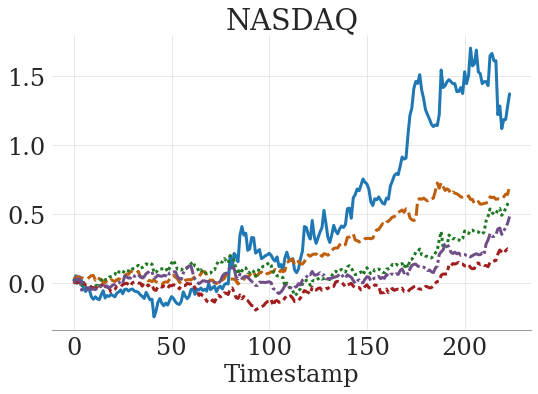

D:\Anaconda\envs\torch\lib\site-packages\ipykernel_launcher.py:67: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.


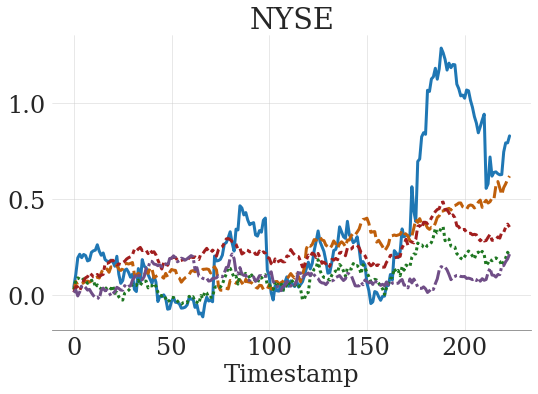

D:\Anaconda\envs\torch\lib\site-packages\ipykernel_launcher.py:67: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.


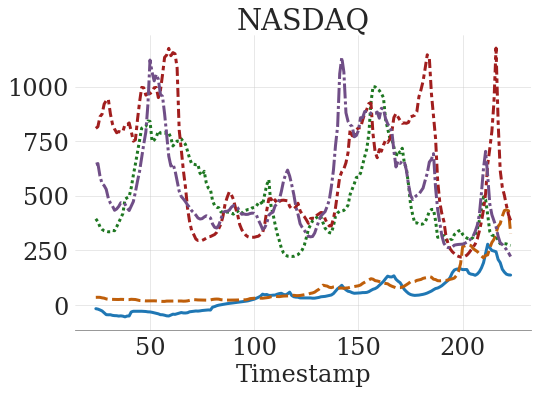

D:\Anaconda\envs\torch\lib\site-packages\ipykernel_launcher.py:67: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.


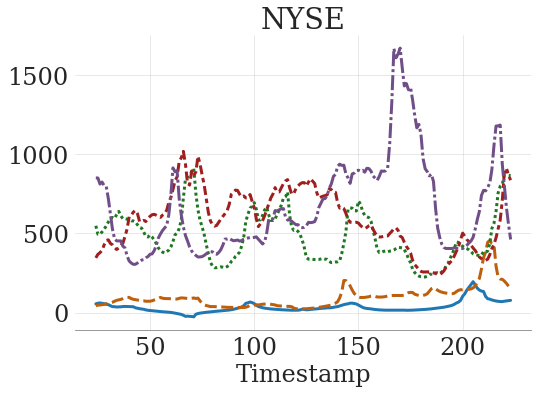

In [15]:
# 分别绘制 NASDAQ 的 IRR5 图
plot_data(df_irr5, 'NASDAQ', 'NASDAQ', 'IRR5', "nasdaq_irr5_comparison_no_yaxis.png")

# 分别绘制 NYSE 的 IRR5 图
plot_data(df_irr5, 'NYSE', 'NYSE', 'IRR5', "nyse_irr5_comparison_no_yaxis.png")

# 分别绘制 NASDAQ 的 Sharpe Ratio 图
plot_data(df_sharpe, 'NASDAQ', 'NASDAQ', 'Rolling Sharpe Ratio', "nasdaq_sharpe_comparison_no_yaxis.png")

# 分别绘制 NYSE 的 Sharpe Ratio 图
plot_data(df_sharpe, 'NYSE', 'NYSE', 'Rolling Sharpe Ratio', "nyse_sharpe_comparison_no_yaxis.png")

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
        # 'SR': [0.5, 0.6, 0.55, 0.7, 0.75, 0.65, 0.8, 0.85, 0.78, 0.9, 0.92, 0.88, 0.95, 0.98, 0.96]
irr1 = {'edge': [128, 128, 128, 256, 256, 256, 512, 512, 512, 1024, 1024, 1024, 2048, 2048, 2048],
        'NASDAQ': [1.00, 0.991, 0.94, 1.08, 0.93, 1.03, 0.82, 0.73, 0.74, 0.75, 0.70, 0.73, 0.66, 0.59, 0.67],
       'NYSE': [0.79, 0.86, 0.78, 0.87, 0.85, 0.86, 0.85, 0.86, 0.85, 0.83, 0.91, 0.89, 0.89, 0.90, 0.90]}

irr2 = {"alpha":[2,4,6,8,10],
        "NASDAQ":[0.83, 0.81, 0.95, 1.08, 0.91],
        "NYSE":[0.75, 0.72, 0.83, 0.89, 0.85]}


irr3 = {"lambda":[0.01,0.05,0.1,0.5,1],
        "NASDAQ":[1.03, 0.95, 0.86, 0.82, 0.66],
        "NYSE":[0.89, 0.76, 0.80, 0.79, 0.81]}

irr4 = {"lookback":[24, 48, 64, 96, 120, 336],
        "NASDAQ":[0.54, 0.62, 0.72, 0.77, 1.03, 0.44],
        "NYSE":[0.35, 0.28, 0.42, 0.63, 0.89, 0.22]}
# 转换为长格式
df = pd.DataFrame(data)
df_long = pd.melt(df, id_vars='edge', value_vars=['IRR_nasdaq', 'IRR_nyse'],
                  var_name='Market', value_name='IRR')

# 绘图
plt.figure(figsize=(10, 8))
sns.boxplot(x='edge', y='IRR', hue='Market', data=df_long, palette=['#1f77b4', '#ff7f0e'])  # 两种颜色

# 样式设置
plt.title('IRR vs. Edge Size')
plt.xlabel('Edge Size')
plt.ylabel('IRR')

# 移除顶部和右侧spines
sns.despine(left=True, right=True, top=True, bottom=True)

# 只保留底部横线（加粗黑色）
ax = plt.gca()
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(2)

# 不显示左侧纵轴的线
ax.spines['left'].set_visible(False)

plt.legend(title='Market')
plt.tight_layout()
plt.show()

KeyError: "The following 'value_vars' are not present in the DataFrame: ['IRR_nasdaq', 'IRR_nyse']"

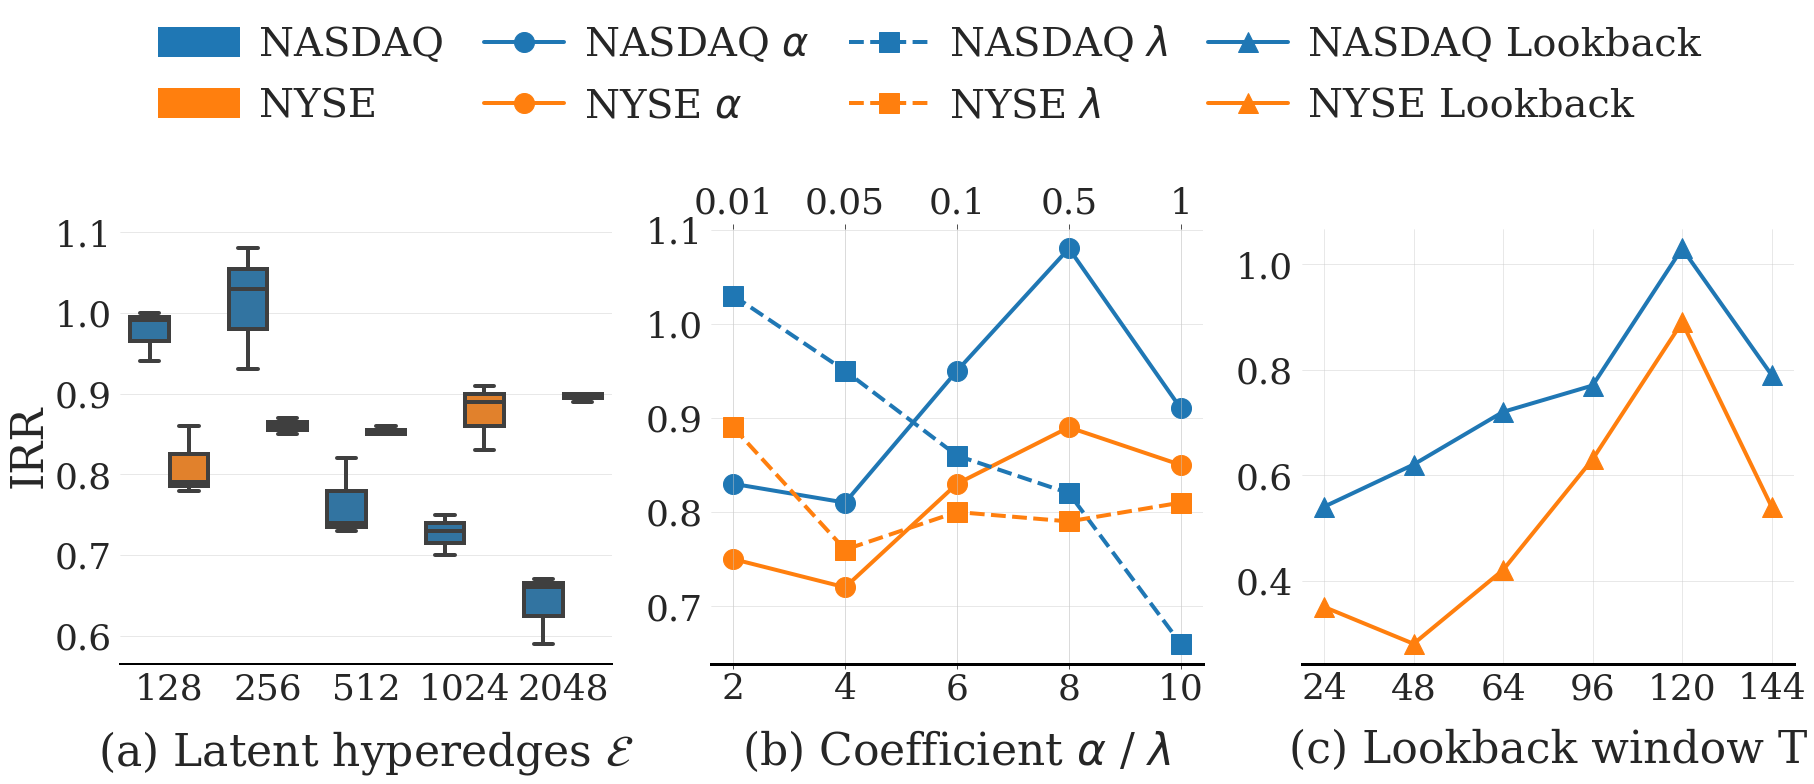

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
# 样式设定
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.family': 'serif',
    'axes.edgecolor': 'grey',
    'font.size': 34,
    'axes.linewidth': 3,
    'grid.linewidth': 0.5,
    'grid.alpha': 0.9,
    'axes.labelsize': 30,
    'xtick.labelsize': 36,
    'ytick.labelsize': 36,
    'legend.fontsize': 34,
    'figure.titlesize': 34,
    'lines.linewidth': 4,
    'lines.markersize': 12,
    'xtick.major.size': 5,
    'ytick.major.size': 5,
    'xtick.minor.size': 1.5,
    'ytick.minor.size': 1.5,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
})

# 颜色与标记
colors = {'NASDAQ': '#1f77b4', 'NYSE': '#ff7f0e'}
markers = {'NASDAQ': 'o', 'NYSE': 's'}

# 数据
irr1 = {'edge': [128, 128, 128, 256, 256, 256, 512, 512, 512, 1024, 1024, 1024, 2048, 2048, 2048],
        'NASDAQ': [1.00, 0.991, 0.94, 1.08, 0.93, 1.03, 0.82, 0.73, 0.74, 0.75, 0.70, 0.73, 0.66, 0.59, 0.67],
        'NYSE': [0.79, 0.86, 0.78, 0.87, 0.85, 0.86, 0.85, 0.86, 0.85, 0.83, 0.91, 0.89, 0.89, 0.90, 0.90]}
irr2 = {"alpha": ["2", "4", "6", "8", "10"],
        "NASDAQ": [0.83, 0.81, 0.95, 1.08, 0.91],
        "NYSE": [0.75, 0.72, 0.83, 0.89, 0.85]}
irr3 = {"lambda": ["0.01", "0.05", "0.1", "0.5", "1"],
        "NASDAQ": [1.03, 0.95, 0.86, 0.82, 0.66],
        "NYSE": [0.89, 0.76, 0.80, 0.79, 0.81]}
irr4 = {"lookback": ["24", "48", "64", "96", "120", "144"],
        "NASDAQ": [0.54, 0.62, 0.72, 0.77, 1.03, 0.79],
        "NYSE": [0.35, 0.28, 0.42, 0.63, 0.89, 0.54]}

# 初始化子图（用 gridspec 保持等高）
fig = plt.figure(figsize=(30, 8))
gs = fig.add_gridspec(1, 3, wspace=0.2)
axes = [fig.add_subplot(gs[0, i]) for i in range(3)]

# --------- 子图1：箱型图 ---------
df1 = pd.DataFrame(irr1)
df1_melt = pd.melt(df1, id_vars='edge', value_vars=['NASDAQ', 'NYSE'], var_name='Market', value_name='IRR')
sns.boxplot(data=df1_melt, x='edge', y='IRR', hue='Market', palette=colors, ax=axes[0])
# axes[0].set_title("(a) IRR vs Edge", loc='left')
axes[0].set_xlabel("")
axes[0].set_ylabel("IRR", fontsize=44)
axes[0].spines['left'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_linewidth(2)
axes[0].spines['bottom'].set_color("black")
axes[0].legend_.remove()  # 去掉箱型图图例


# --------- 子图2：双横轴折线图 ---------
df2 = pd.DataFrame(irr2)
df3 = pd.DataFrame(irr3)

# 主轴：irr2 - alpha 用圆点
for market in ['NASDAQ', 'NYSE']:
    axes[1].plot(df2["alpha"], df2[market],
                 label=f'{market} (alpha)',
                 marker='o', color=colors[market], linestyle='-', markersize=20)


# 副轴：lambda（虚线）
ax2_top = axes[1].twiny()
ax2_top.set_xticks(range(len(irr3["lambda"])))
ax2_top.set_xticklabels(irr3["lambda"])
# ax2_top.set_xlabel(r"$\lambda$", labelpad=2)
ax2_top.spines["top"].set_position(("axes", 1.0))
ax2_top.patch.set_visible(False)
# lambda 用方框
for market in ['NASDAQ', 'NYSE']:
    ax2_top.plot(df3["lambda"], df3[market],
                 label=f'{market} (lambda)',
                 marker='s', color=colors[market], linestyle='--', markersize=20)


# axes[1].set_xlabel(r"$\alpha$")
# axes[1].set_title("(b) IRR vs Alpha / Lambda", loc='left')
for ax in [axes[1], ax2_top]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['bottom'].set_color("black")


# --------- 子图3：lookback ---------
df4 = pd.DataFrame(irr4)
for market in ['NASDAQ', 'NYSE']:
    axes[2].plot(df4["lookback"], df4[market],
                 label=market,
                 marker='^', color=colors[market], linestyle='-', markersize=20)

# axes[2].set_xlabel("Lookback window length")
# axes[2].set_title("(c) IRR vs Lookback", loc='left')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].spines['left'].set_visible(False)
axes[2].spines['bottom'].set_linewidth(3)
axes[2].spines['bottom'].set_color("black")

# --------- 全局图例 ---------
# 颜色图例（代表市场），用空心方框，模拟箱型图图例
color_legend_handles = [
    Rectangle((0,0),1,1, linewidth=2, color=colors['NASDAQ'], label='NASDAQ'),
    Rectangle((0,0),1,1, linewidth=2, color=colors['NYSE'], label='NYSE'),
]

# 线+marker图例（表示折线图的alpha/lambda/lookback）
line_marker_legend_handles = [
    Line2D([0], [0], color=colors['NASDAQ'], marker='o', linestyle='-', markersize=20,label=r'NASDAQ $\alpha$'),
    Line2D([0], [0], color=colors['NYSE'], marker='o', linestyle='-', markersize=20,label=r'NYSE $\alpha$'),
    Line2D([0], [0], color=colors['NASDAQ'], marker='s', linestyle='--', markersize=20,label=r'NASDAQ $\lambda$'),
    Line2D([0], [0], color=colors['NYSE'], marker='s', linestyle='--', markersize=20,label=r'NYSE $\lambda$'),
    Line2D([0], [0], color=colors['NASDAQ'], marker='^', linestyle='-', markersize=20, label=r'NASDAQ Lookback'),
    Line2D([0], [0], color=colors['NYSE'], marker='^', linestyle='-', markersize=20,label=r'NYSE Lookback')
]

# 合并图例句柄
all_legend_handles = color_legend_handles + line_marker_legend_handles

# 添加统一图例（放最上面，居中）
fig.legend(handles=all_legend_handles, loc='upper center', ncol=4,
           frameon=False, bbox_to_anchor=(0.5, 1.3), fontsize=40,
           handletextpad=0.5, labelspacing=0.6, columnspacing=1)

axes[0].text(0.5, -0.15, "(a) Latent hyperedges $\mathcal{E}$", transform=axes[0].transAxes,
             ha='center', va='top', fontsize=44)

axes[1].text(0.5, -0.15, r"(b) Coefficient $\alpha$ / $\lambda$", transform=axes[1].transAxes,
             ha='center', va='top', fontsize=44)

axes[2].text(0.5, -0.15, "(c) Lookback window T", transform=axes[2].transAxes,
             ha='center', va='top', fontsize=44)

# --------- 输出 ---------
plt.savefig("irr_combined_final.png", dpi=900, bbox_inches='tight')
plt.show()


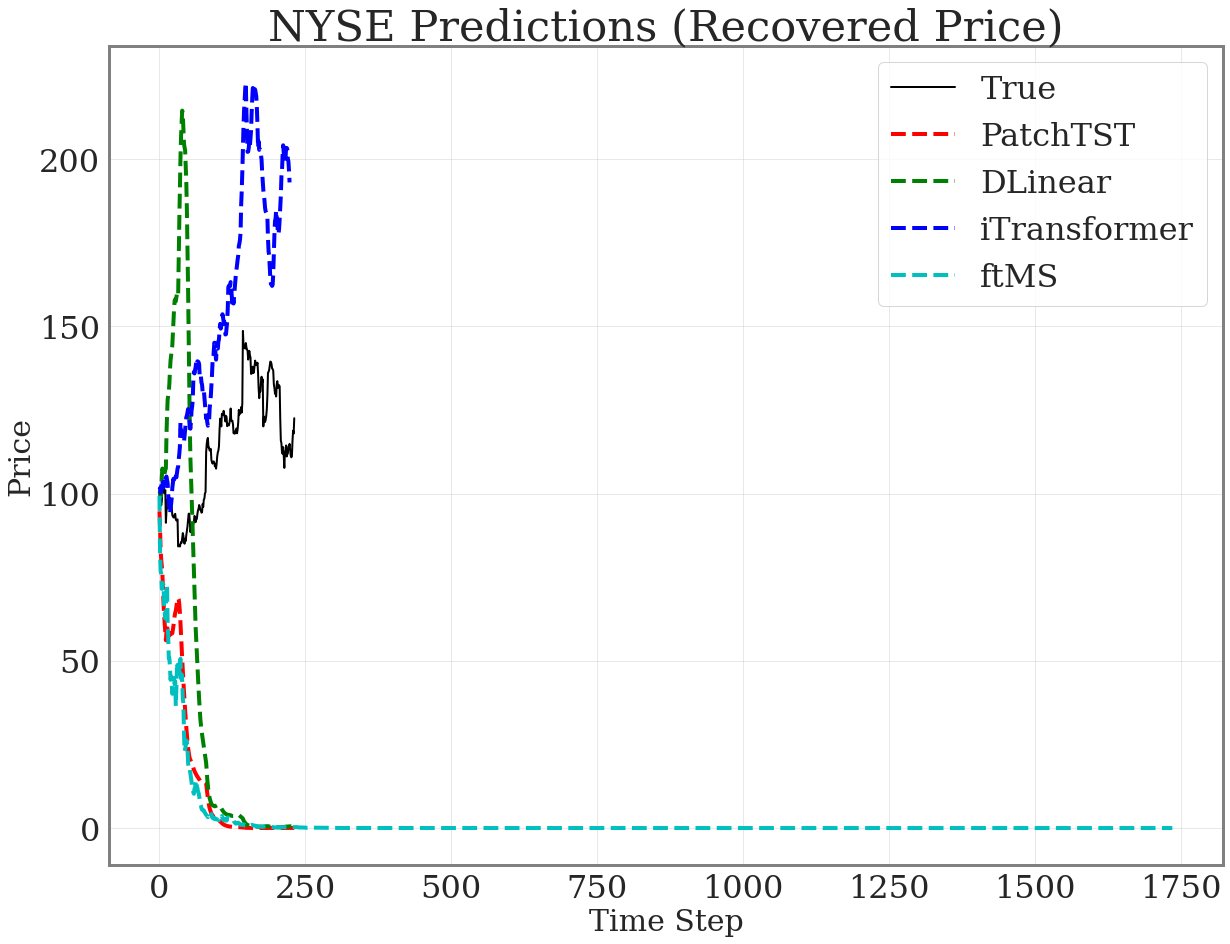

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
path_nyse = ["../results/long_term_forecast_NASDAQ_120_1_PatchTST_NASDAQ_baseline_ftMS_sl120_ll0_pl1_dm24_nh16_el5_lr0.00015_lsMSE_bs8_a8.0_nyse_0",
           "../results/long_term_forecast_NASDAQ_120_1_DLinear_NASDAQ_baseline_ftMS_sl120_ll0_pl1_dm24_nh16_el5_lr0.00015_lsMSE_bs8_a10_nyse_0",
           "../results/long_term_forecast_NASDAQ_24_1_iTransformer_NASDAQ_baseline_ftMS_sl24_ll0_pl1_dm16_nh16_el5_lr0.001_lsMSE_bs32_a10_nyse_0",
            "../results/long_term_forecast_NYSEtest_STHMamba_NASDAQ_ftMS_sl120_ll0_pl1_dm24_nh4_el2_lr0.00015_lsrank_bs8_a9.0_final_re_2"]
def recover_price_from_return(ret_series, init_price):
    # ret_series: shape (time,)
    return init_price * np.cumprod(1 + ret_series)

def plot_price_preds(paths, title, init_price=100, save_path=None):
    plt.figure(figsize=(18, 14))

    colors = ['r', 'g', 'b', 'c', 'm', 'y']

    # 真实值（return -> price）
    true_ret = np.load(os.path.join(paths[0], "true.npy"))[1]
    true_price = recover_price_from_return(true_ret, init_price)
    plt.plot(true_price, color='k', label='True', linewidth=2)

    for i, path in enumerate(paths):
        pred_ret = np.load(os.path.join(path, "pred.npy"))[1]
        pred_price = recover_price_from_return(pred_ret, init_price)
        model_name = os.path.basename(path).split("_")[6]
        plt.plot(pred_price, color=colors[i % len(colors)], linestyle='--', label=model_name)

    plt.title(f"{title} (Recovered Price)")
    plt.xlabel("Time Step")
    plt.ylabel("Price")
    plt.legend()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

# 使用示例
# plot_price_preds(path_nas, "NASDAQ Predictions", init_price=100)
plot_price_preds(path_nyse, "NYSE Predictions", init_price=100)


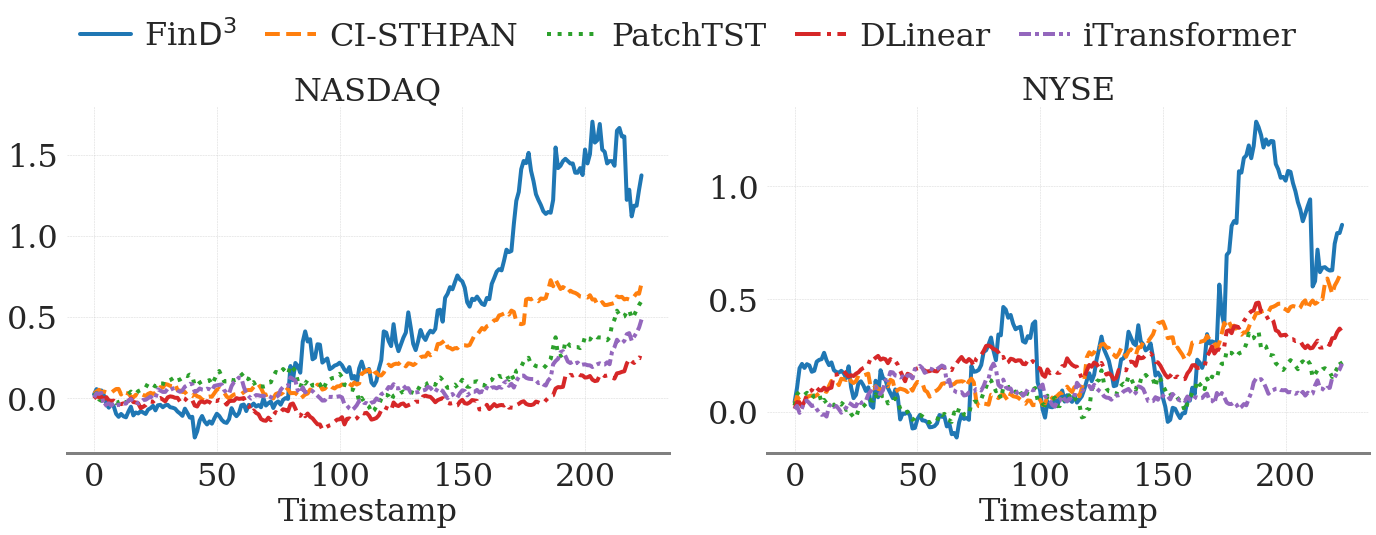

In [19]:
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
plt.rcParams.update({
    'font.family': 'serif',
    'axes.edgecolor': 'grey',
    'font.size': 36,
    'axes.linewidth': 3,
    'grid.linewidth': 0.5,
    'grid.alpha': 0.9,  # 淡化网格线
    # 'figure.figsize': (8, 6),
    'axes.labelsize': 30,
    'xtick.labelsize': 32,
    'ytick.labelsize': 32,
    'legend.fontsize': 32,
    'figure.titlesize': 28,
    'lines.linewidth': 4,
    'lines.markersize': 5,
    'xtick.major.size': 5,
    'ytick.major.size': 5,
    'xtick.minor.size': 1.5,
    'ytick.minor.size': 1.5,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    # 'legend.frameon': False
})


model_list = ['Fin$\mathrm{D}^3$','CI-STHPAN', 'PatchTST', 'DLinear', 'iTransformer']
# 配色和线型
linestyles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1))]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# 提取对应列（按顺序自定义）
nasdaq_keys = [k for k in df_irr5.columns if "NASDAQ" in k]
nyse_keys = [k for k in df_irr5.columns if "NYSE" in k]

# 图形创建
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharex=True)

# --- NASDAQ ---
for i, key in enumerate(nasdaq_keys):
    axes[0].plot(df_irr5[key], label=model_list[i], 
                 linestyle=linestyles[i % len(linestyles)],
                 color=colors[i % len(colors)])
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_visible(False) # 去掉 Y 轴线
axes[0].set_title("NASDAQ", fontsize=32)
axes[0].set_xlabel("Timestamp", fontsize=32)
axes[0].grid(True, linestyle='--', alpha=0.8)

# --- NYSE ---
for i, key in enumerate(nyse_keys):
    axes[1].plot(df_irr5[key], label=model_list[i], 
                 linestyle=linestyles[i % len(linestyles)],
                 color=colors[i % len(colors)])
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False) # 去掉 Y 轴线
axes[1].set_title("NYSE", fontsize=32)
axes[1].set_xlabel("Timestamp", fontsize=32)
axes[1].grid(True, linestyle='--', alpha=0.8)

# 图例统一放上方
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='upper center',
    ncol=len(labels),
    frameon=False,
    bbox_to_anchor=(0.5, 1),
    handlelength=1.6,
    handletextpad=0.4,
    labelspacing=0.6,
    columnspacing=0.9,
    fontsize=32
)

# 美化与保存
plt.tight_layout()
plt.subplots_adjust(top=0.8)
plt.savefig("irr5.png", dpi=900)
plt.show()


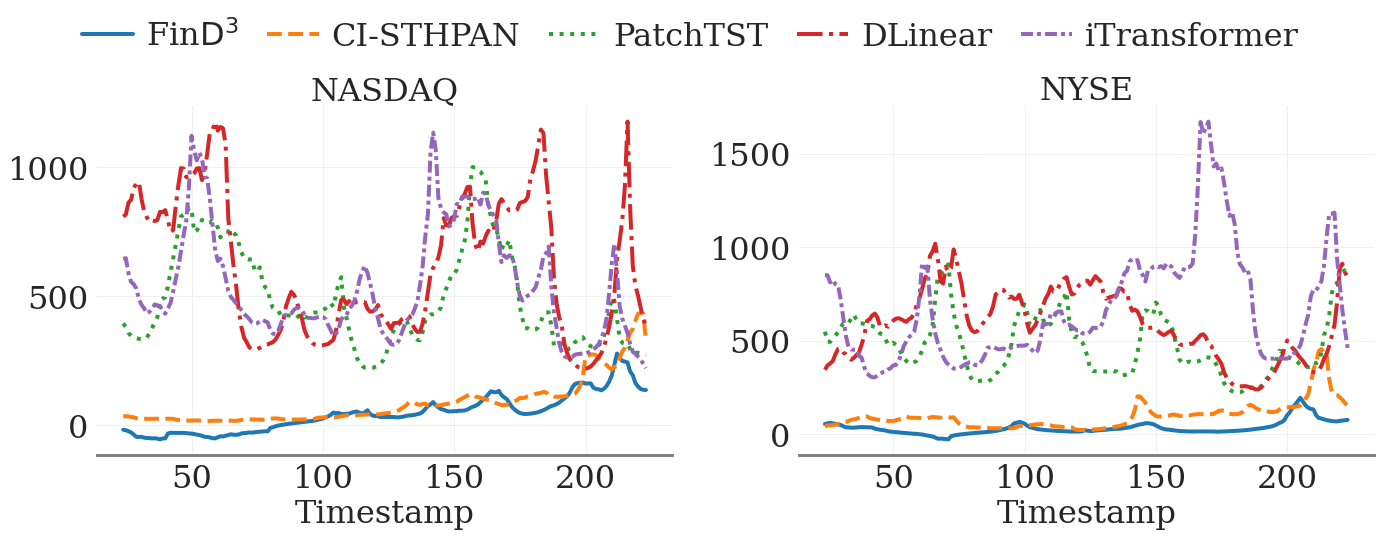

In [20]:
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
plt.rcParams.update({
    'font.family': 'serif',
    'axes.edgecolor': 'grey',
    'font.size': 34,
    'axes.linewidth': 3,
    'grid.linewidth': 0.5,
    'grid.alpha': 0.9,  # 淡化网格线
    # 'figure.figsize': (8, 6),
    'axes.labelsize': 30,
    'xtick.labelsize': 32,
    'ytick.labelsize': 32,
    'legend.fontsize': 32,
    'figure.titlesize': 28,
    'lines.linewidth': 4,
    'lines.markersize': 5,
    'xtick.major.size': 5,
    'ytick.major.size': 5,
    'xtick.minor.size': 1.5,
    'ytick.minor.size': 1.5,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    # 'legend.frameon': False
})
model_list = ['Fin$\mathrm{D}^3$','CI-STHPAN', 'PatchTST', 'DLinear', 'iTransformer']
# 配色和线型
linestyles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1))]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# 提取对应列（按顺序自定义）
nasdaq_keys = [k for k in df_sharpe.columns if "NASDAQ" in k]
nyse_keys = [k for k in df_sharpe.columns if "NYSE" in k]

# 图形创建
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharex=True)

# --- NASDAQ ---
for i, key in enumerate(nasdaq_keys):
    axes[0].plot(df_sharpe[key], label=model_list[i], 
                 linestyle=linestyles[i % len(linestyles)],
                 color=colors[i % len(colors)])
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_visible(False) # 去掉 Y 轴线
axes[0].set_title("NASDAQ", fontsize=32)
axes[0].set_xlabel("Timestamp",fontsize=32)
axes[0].grid(True, linestyle='--', alpha=0.8)

# --- NYSE ---
for i, key in enumerate(nyse_keys):
    axes[1].plot(df_sharpe[key], label=model_list[i], 
                 linestyle=linestyles[i % len(linestyles)],
                 color=colors[i % len(colors)])
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False) # 去掉 Y 轴线
axes[1].set_title("NYSE", fontsize=32)
axes[1].set_xlabel("Timestamp", fontsize=32)
axes[1].grid(True, linestyle='--', alpha=0.8)

# 图例统一放上方
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='upper center',
    ncol=len(labels),
    frameon=False,
    bbox_to_anchor=(0.5, 1),
    handlelength=1.6,
    handletextpad=0.4,
    labelspacing=0.6,
    columnspacing=0.9,
    fontsize=32
)
# 美化与保存
plt.tight_layout()
plt.subplots_adjust(top=0.8)
plt.savefig("rollingSR.png", dpi=900)
plt.show()
